500 hPa Vorticity Advection
===========================

Plot an 500-hPa map with calculating vorticity advection using MetPy calculations.

Beyond just plotting 500-hPa level data, this uses calculations from `metpy.calc` to find
the vorticity and vorticity advection. Currently, this needs an extra helper function to
calculate the distance between lat/lon grid points.

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
import xarray as xr

Function to Compute Earth-Relative Winds
----------------------------------------

This function takes a data array with relevant information about the
projection of the wind component data, along with the grid-relative
components of the wind. It outputs the earth-relative components of the
wind.


In [2]:
def earth_relative_wind_components(ugrd, vgrd):
    """Calculate the north-relative components of the
    wind from the grid-relative components using Cartopy
    transform_vectors.

    Parameters
    ----------
        ugrd : Xarray DataArray (M, N)
            grid relative u-component of the wind
        vgrd : Xarray DataArray (M, N)
            grid relative v-component of the wind

    Returns
    -------
        unr, vnr : tuple of array-like Quantity
            The north-relative wind components in the X (East-West)
            and Y (North-South) directions, respectively.
    """
    if 'metpy_crs' not in ugrd.coords:
        raise ValueError('No CRS in coordinate, be sure to use'
                         'the MetPy accessor parse_cf()')

    data_crs = ugrd.metpy.cartopy_crs

    x = ugrd.x.values
    y = ugrd.y.values

    xx, yy = np.meshgrid(x, y)

    ut, vt = ccrs.PlateCarree().transform_vectors(data_crs, xx, yy,
                                                  ugrd.values, vgrd.values)

    # Make a copy of u and v component DataArrays
    uer = ugrd.copy()
    ver = vgrd.copy()

    # Update values with transformed winds
    uer.values = ut
    ver.values = vt

    return uer, ver


Data Aquisition
---------------

In [3]:
dt = datetime(2016, 4, 16, 18)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-namanl-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'namanl_218_{dt:%Y%m%d}_{dt:%H}00_000.grb'].subset()

# Query for Latest GFS Run
query = ncss.query()

query.time(dt)
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Obtain our queried data
data = ncss.get_data(query)
ds_data = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()
ds = ds_data.metpy.assign_latitude_longitude()

times = ds.Geopotential_height_isobaric.metpy.time
vtime = times.values.squeeze().astype('datetime64[ms]').astype('O')

lev_500 = 500 * units.hPa

hght_500 = ds.Geopotential_height_isobaric.metpy.sel(
    vertical=lev_500).squeeze()
hght_500 = mpcalc.smooth_gaussian(hght_500, 4)

uwnd_500 = ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=lev_500).squeeze()
vwnd_500 = ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=lev_500).squeeze()

# Compute north-relative wind components for calculation purposes
uwnd_500er, vwnd_500er = earth_relative_wind_components(uwnd_500, vwnd_500)

Begin Data Calculations
-----------------------

In [4]:
avor = mpcalc.vorticity(uwnd_500er, vwnd_500er)

avor = mpcalc.smooth_n_point(avor, 9, 10) * 1e5

vort_adv = mpcalc.advection(avor, uwnd_500er, vwnd_500er) * 1e4

/var/folders/fp/_l45s1m93s5009vb713pyg580000gn/T/ipykernel_51141/3729036084.py:5: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  vort_adv = mpcalc.advection(avor, uwnd_500er, vwnd_500er) * 1e4


Map Creation
------------

/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kgoebber/miniconda3/envs/main/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: 

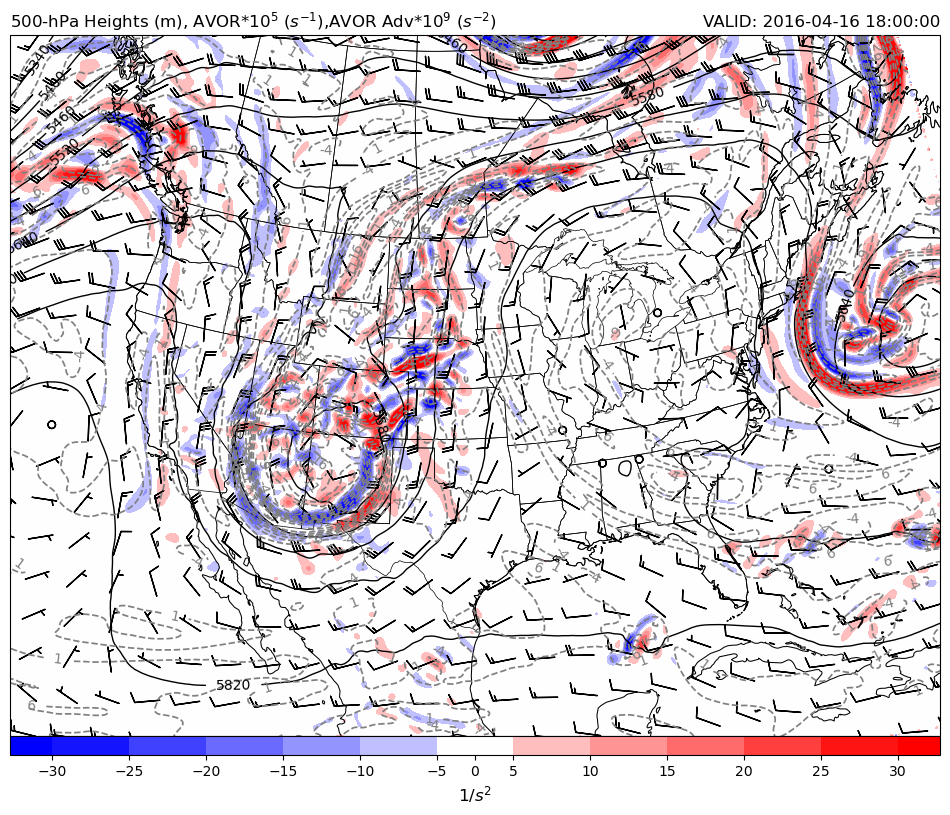

In [5]:
# Set up Coordinate System for Plot and Transforms
datacrs = ds.Geopotential_height_isobaric.metpy.cartopy_crs
plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                standard_parallels=[30, 60])

fig = plt.figure(1, figsize=(12., 14.))
ax = plt.subplot(111, projection=plotcrs)

# Plot Titles
plt.title(r'500-hPa Heights (m), AVOR$*10^5$ ($s^{-1}$),'
          'AVOR Adv$*10^9$ ($s^{-2}$)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

# Plot Background
ax.set_extent([235., 290., 20., 58.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev500 = np.arange(5100, 6061, 60)
cs = ax.contour(hght_500.longitude, hght_500.latitude,
                hght_500, clev500,
                colors='black', linewidths=1.0,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Absolute Vorticity Contours
clevvort500 = np.arange(-9, 50, 5)
cs2 = ax.contour(avor.longitude, avor.latitude,
                 avor, clevvort500,
                 colors='grey', linewidths=1.25, linestyles='dashed',
                 transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Vorticity Advection
clev_avoradv = np.arange(-30, 31, 5)
cf = ax.contourf(vort_adv.longitude, vort_adv.latitude, vort_adv,
                 clev_avoradv[clev_avoradv != 0], extend='both',
                 cmap='bwr', transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50,
                  extendrect='True', ticks=clev_avoradv)
cb.set_label(r'$1/s^2$', size='large')

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = (slice(None, None, 20), slice(None, None, 20))
xx, yy = np.meshgrid(uwnd_500.x.values[wind_slice[0]],
                     uwnd_500.y.values[wind_slice[0]])
ax.barbs(xx, yy, uwnd_500.values[wind_slice], vwnd_500.values[wind_slice],
         length=6, pivot='middle', transform=datacrs)